# Project work for Machine Learning Intermediate (ML2) - INSAID

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import metrics
%matplotlib inline

### About dataset

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>

Our objective is to build a classifier, to predict the class of unknown cases.

### Load Data From CSV File  

In [2]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
cell_df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

In [4]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID             699 non-null int64
Clump          699 non-null int64
UnifSize       699 non-null int64
UnifShape      699 non-null int64
MargAdh        699 non-null int64
SingEpiSize    699 non-null int64
BareNuc        699 non-null object
BlandChrom     699 non-null int64
NormNucl       699 non-null int64
Mit            699 non-null int64
Class          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [5]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

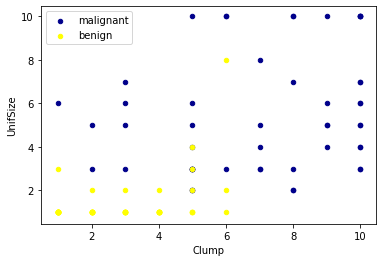

In [6]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

In [7]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign =2 or malignant =4). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

Lets plot some columns to underestand data better:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f53c940>]],
      dtype=object)

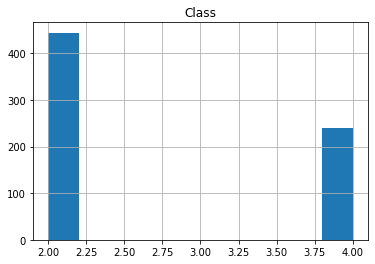

In [9]:
cell_df.hist(column='Class')

In [10]:
cell_df['Class'].value_counts()

2    444
4    239
Name: Class, dtype: int64

#### 444 Benign, 239 Malignant


### Feature set

Lets define feature sets, X:

In [11]:
cell_df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

## Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice.

In [12]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.19790469, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299,  0.75803177,  1.69516613,
         1.77286724, -0.18182716, -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.4242175 , -0.18182716, -0.61292736, -0.34839971],
       [ 0.55267873,  1.58320366,  1.6021918 , -0.63936553, -0.10545357,
         0.12505369, -0.18182716,  1.3540079 , -0.34839971],
       [-0.15686934, -0.70221201, -0.74177362,  0.05933312, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971]])

### Train Test Split  


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression
- Naive Bayes


# K Nearest Neighbor(KNN)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split the dataset into training and test set: test size = 20% of dataset
# This dataset will be used for each alogrithm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [20]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.97810219, 0.96350365, 0.97080292, 0.97810219, 0.97080292,
       0.97810219, 0.97810219, 0.98540146, 0.97810219, 0.98540146,
       0.97080292, 0.97810219, 0.96350365, 0.97810219])

#### Plot  model accuracy  for Different number of Neighbors 

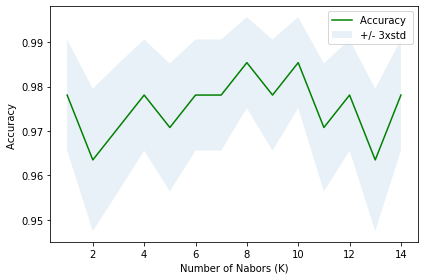

In [21]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [22]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.9854014598540146 with k= 8


In [24]:
neigh = KNeighborsClassifier(n_neighbors = 5).fit(X_train,y_train)
y_KNN_Predit=neigh.predict(X_test)
mean_acc = metrics.accuracy_score(y_test, y_KNN_Predit)

print("jaccard_similarity_score" , jaccard_similarity_score(y_test,y_KNN_Predit))
print("f1_score" , f1_score(y_test,y_KNN_Predit, average='weighted'))

jaccard_similarity_score 0.9708029197080292
f1_score 0.9710669934861801


/Users/dhanbhan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Implement the decision tree model and measure the accuracy score
dt = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
dt.fit(X_train,y_train)
y_DT_pred = dt.predict(X_test)
print("Decision trees's accuracy: {}".format(accuracy_score(y_test, y_DT_pred)))
print("jaccard_similarity_score" , jaccard_similarity_score(y_test,y_DT_pred))
print("f1_score" , f1_score(y_test,y_DT_pred, average='weighted'))

Decision trees's accuracy: 0.9343065693430657
jaccard_similarity_score 0.9343065693430657
f1_score 0.9343932313743836


/Users/dhanbhan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Support Vector Machine

In [44]:
from sklearn.svm import SVC

# Implement SVM with various kernels and measure the accuracy score for each
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
SVM_acc_score = np.zeros((len(kernel)))
for i,k in enumerate(kernel):
    clssfr = SVC(gamma='auto',kernel=k)
    clssfr.fit(X_train, y_train)
    y_SVM_pred = clssfr.predict(X_test)
    SVM_acc_score[i] = accuracy_score(y_test, y_SVM_pred)

# Print the accuracy score of each SVM model
print("SVM's Accuracy: ")
for i,k in enumerate(kernel):
    print("kernel = {} -> acc = {}".format(k,SVM_acc_score[i]))

# Obtain the best performing kernel based on accuracy score on the test set and retrieve the corresponding SVM model
i_opt = np.argmax(SVM_acc_score)
svm_opt = SVC(gamma='auto',kernel=kernel[i_opt])
svm_opt.fit(X_train, y_train)
y_SVM_opt_pred = svm_opt.predict(X_test)
print("jaccard_similarity_score" , jaccard_similarity_score(y_test,y_SVM_opt_pred))
print("f1_score" , f1_score(y_test,y_SVM_opt_pred, average='weighted'))

SVM's Accuracy: 
kernel = linear -> acc = 0.9635036496350365
kernel = poly -> acc = 0.948905109489051
kernel = rbf -> acc = 0.948905109489051
kernel = sigmoid -> acc = 0.9197080291970803
jaccard_similarity_score 0.9635036496350365
f1_score 0.9635517952079908


/Users/dhanbhan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


#### Kernal=linear turnsout to be best model for SVM

# Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

# Implement the logistic regression for many regularization parameters and measure the accuracy score for each
reg = np.logspace(-4,0,5)
LR_acc_score = np.zeros((len(reg)))
for i,k in enumerate(reg):
    lr = LogisticRegression(C=k, solver='liblinear').fit(X_train,y_train)
    y_LR_pred = lr.predict(X_test)
    LR_acc_score[i] = accuracy_score(y_test, y_LR_pred)

# Print the accuracy score of each LR model
print("LR's Accuracy: ")
for i,k in enumerate(reg):
    print("regularization = {} -> acc = {}".format(k,LR_acc_score[i]))

# Obtain the best regularization parameter based on accuracy score on the test set and retrieve the 
# corresponding LR model
i_opt = np.argmax(LR_acc_score)
lr_opt = LogisticRegression(C=reg[i_opt], solver='liblinear')
lr_opt.fit(X_train, y_train)
y_LR_opt_pred = lr_opt.predict(X_test)

print("jaccard_similarity_score" , jaccard_similarity_score(y_test,y_LR_opt_pred))
print("f1_score" , f1_score(y_test,y_LR_opt_pred, average='weighted'))
print("Logloss_LR" , log_loss(y_test, lr_opt.predict_proba(X_test)))

LR's Accuracy: 
regularization = 0.0001 -> acc = 0.9562043795620438
regularization = 0.001 -> acc = 0.9562043795620438
regularization = 0.01 -> acc = 0.9708029197080292
regularization = 0.1 -> acc = 0.9635036496350365
regularization = 1.0 -> acc = 0.9635036496350365
jaccard_similarity_score 0.9708029197080292
f1_score 0.9708029197080292
Logloss_LR 0.1879930537902931


/Users/dhanbhan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


#### Regularization = 0.01 gave a good model for logistic regression with liblinear solver. 

# Naive Bayes

In [50]:
from sklearn.naive_bayes import MultinomialNB

XNB = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']] .values  #.astype(float)

yNB = np.asarray(cell_df['Class'])
from sklearn.model_selection import train_test_split
XNB_train, XNB_test, yNB_train, yNB_test = train_test_split( XNB, yNB, test_size=0.2, random_state=4)

naive_bayes = MultinomialNB()
naive_bayes.fit(XNB_train,yNB_train)

y_NB_opt_pred = naive_bayes.predict(XNB_test)

print('Accuracy score: {}'.format(accuracy_score(yNB_test, y_NB_opt_pred)))
print("f1_score" , f1_score(y_test,y_NB_opt_pred, average='weighted'))

Accuracy score: 0.8978102189781022
f1_score 0.514794671737542


# Model Evaluation using Test set

| Algorithm          | Accuracy| F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 96.35%  | 96.35%   | NA      |
| Decision Tree      | 93.43%  | 93.44%   | NA      |
| SVM                | 96.35%  | 96.35%   | NA      |
| LogisticRegression | 97.08%  | 97.08%   | 18.8%   |
| Naive Bayes        | 89.78%  | 51.47%   | xxxx    |

### From above matrix we can rely on model created using Logistic regression algoritm which has higher accuracy score followed by KNN and SVM.